In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import os
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
#from torchnet.meter import AverageValueMeter
import torch.backends.cudnn as cudnn

import matplotlib.pyplot as plt
import os, json
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm, trange
import cv2
import torchvision.models as models
from torchsummary import summary


import os
import torch
from torch import nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
from utils import depthToLogDepth



In [2]:
data_dir = Path("/home/michael/Desktop/projects/ROAR/data/output")
center_depth_dir = data_dir / "front_depth"
center_rgb_dir = data_dir / "front_rgb"
veh_state_dir = data_dir / "vehicle_state"

center_depth_paths = [p for p in sorted(center_depth_dir.glob("*.npy", ), key=os.path.getmtime)]
center_rgb_paths = [p for p in sorted(center_rgb_dir.glob("*.png", ), key=os.path.getmtime)]
veh_state_paths = [p for p in sorted(veh_state_dir.glob("*.npy", ), key=os.path.getmtime)]
assert len(center_depth_paths) == len(center_rgb_paths) == len(veh_state_paths)
print(f"Found { len(center_rgb_paths)} data points")

Found 118577 data points


Below would take some time

In [3]:
steerings , throttles = [0]*len(center_rgb_paths), [0]*len(center_rgb_paths)
for i in tqdm(range(len(center_rgb_paths))):
    state = np.load(veh_state_paths[i])
    steerings[i] = state[-1]
    throttles[i] = state[-2]
df = pd.DataFrame({"rgb_path": center_rgb_paths, "steering":steerings, "throttle": throttles})

  0%|          | 0/118577 [00:00<?, ?it/s]

#### Some data exploration

In [4]:
df.head()

,rgb_path,steering,throttle
0,/home/michael/Desktop/projects/ROAR/data/outpu...,0.053245,1.0
1,/home/michael/Desktop/projects/ROAR/data/outpu...,0.044596,1.0
2,/home/michael/Desktop/projects/ROAR/data/outpu...,0.035562,1.0
3,/home/michael/Desktop/projects/ROAR/data/outpu...,0.035561,1.0
4,/home/michael/Desktop/projects/ROAR/data/outpu...,0.035561,1.0


In [5]:
df.describe()

,steering,throttle
count,118577.000000,118577.000000
mean,-0.007236,0.604110
std,0.094685,0.345911
min,-0.640327,0.000000
25%,-0.068903,0.466233
50%,-0.006032,0.588960
75%,0.061620,1.000000
max,0.733144,1.000000


array([[<AxesSubplot:title={'center':'steering'}>,
        <AxesSubplot:title={'center':'throttle'}>]], dtype=object)

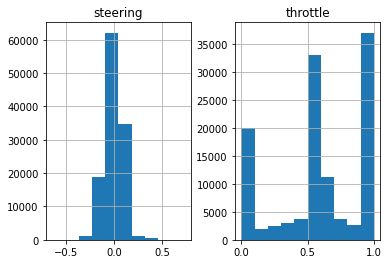

In [6]:
df.hist()

In [7]:
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    def __getitem__(self, index):
        rgb_path = self.df.iloc[index]["rgb_path"].as_posix()
        steering = self.df.iloc[index]["steering"]
        throttle = self.df.iloc[index]["throttle"]
        img = cv2.resize(cv2.imread(rgb_path), dsize=(64,64))
#         img = np.swapaxes(img, 0, 2)
        return img, steering
        
    def __len__(self):
        return len(self.df)

(<matplotlib.image.AxesImage at 0x7f0668fbb580>, 0.0355633869767189)

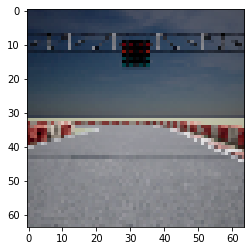

In [8]:
ds = CarDataset(df)
img, steering = ds[10]
# plt.imshow(np.swapaxes(img, 0, 2)[:,:,::-1]), steering
plt.imshow(img[:,:,::-1]), steering
# np.shape(img)

In [9]:
def load_resnet18(num_classes=2):
    # Load the pre-trained model (on ImageNet)
    model = models.resnet18(pretrained=True)

    # Don't allow model feature extraction layers to be modified
    for layer in model.parameters():
        layer.requires_grad = False

    # Change the classifier layer
    model.fc = nn.Linear(512, num_classes)

    for param in model.fc.parameters():
        param.requires_grad = True

    return model


In [95]:
def get_default_transform():
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    input_size = (600, 800)

    transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    return transform

class ResNet18(pl.LightningModule):
    def __init__(self, input_shape=(1, 64, 64, 3), output_size=(1,)):
        super().__init__()

        # Used by PyTorch Lightning to print an example model summary
        self.example_input_array = torch.rand(input_shape)

        # Metrics
        self.train_mse = torchmetrics.regression.mean_squared_error.MeanSquaredError()
        self.valid_mse = torchmetrics.regression.mean_squared_error.MeanSquaredError()

        self.model = load_resnet18(num_classes=output_size[0])
        
        self.inference_transform = get_default_transform()

        
        # Keep track of the loss history. This is useful for writing tests
        self.loss_history = []

    def forward(self, x):
        # Forward defines the prediction/inference action
        x = torch.permute(x, (0,3,1,2))
        r = self.model(x.float()).reshape((1,))
        
        return r

    def training_step(self, batch, batch_idx):
        x, y = batch
        y = y.float()
        x = x.float()
        x = torch.permute(x, (0,3,1,2))

        logits = self.model(x).reshape((1,))
        print(x.shape, y.shape, logits.shape)

        loss = F.l1_loss(logits, y)
        self.loss_history.append(loss)
        self.log("train_loss", loss)
        # Log Metrics
        self.train_mse(logits, y)
        self.log("train_mse", self.train_mse, on_step=False, on_epoch=True)
        print("loss from train step", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.l1_loss(logits, y)

        self.log("val_loss", loss)

        # Log Metrics
        self.valid_mse(logits, y)
        self.log("valid_mse", self.valid_mse, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=0.0001, weight_decay=0.0005)
        return optimizer

    def run(self, img_arr: np.ndarray, other_arr: np.ndarray = None):
        """
        Donkeycar parts interface to run the part in the loop.
        :param img_arr:     uint8 [0,255] numpy array with image data
        :param other_arr:   numpy array of additional data to be used in the
                            pilot, like IMU array for the IMU model or a
                            state vector in the Behavioural model
        :return:            tuple of (angle, throttle)
        """
        from PIL import Image

        pil_image = Image.fromarray(img_arr)
        tensor_image = self.inference_transform(pil_image)
        tensor_image = tensor_image.unsqueeze(0)
        print("unsqueezed")
        # Result is (1)
        result = self.forward(tensor_image)
        print("forwarded")
        # Resize to (1,)
        result = result.reshape(-1)
        print("reshaped")
        # Convert from being normalized between [0, 1] to being between [-1, 1]
        result = result * 2 - 1
        print("ResNet18 result: {}".format(result))
        return result

In [96]:
num_train, num_valid, num_test = int(len(ds)*0.8), int(len(ds)*0.1), len(ds) - int(len(ds)*0.8) - int(len(ds)*0.1)
train, valid, test = random_split(ds, [num_train,num_valid,num_test])
len(train), len(valid), len(test)

(94861, 11857, 11859)

In [97]:

logger = TensorBoardLogger('tb_logs', name="rgb")
output_dir = Path("./data")
model = ResNet18()

In [98]:
trainer = pl.Trainer(
    gpus=-1, logger=logger, progress_bar_refresh_rate=30,
    max_epochs=3,  default_root_dir=output_dir, weights_summary='full'
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [99]:
train_dataloader = DataLoader(train, shuffle=True, batch_size=1)
valid_dataloader = DataLoader(valid, shuffle=True, batch_size=1)

In [100]:
trainer.fit(model, train_dataloader, valid_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                        | Type              | Params | In sizes        | Out sizes      
-------------------------------------------------------------------------------------------------------
0  | train_mse                   | MeanSquaredError  | 0      | ?               | ?              
1  | valid_mse                   | MeanSquaredError  | 0      | ?               | ?              
2  | model                       | ResNet            | 11.2 M | [1, 3, 64, 64]  | [1, 1]         
3  | model.conv1                 | Conv2d            | 9.4 K  | [1, 3, 64, 64]  | [1, 64, 32, 32]
4  | model.bn1                   | BatchNorm2d       | 128    | [1, 64, 32, 32] | [1, 64, 32, 32]
5  | model.relu                  | ReLU              | 0      | [1, 64, 32, 32] | [1, 64, 32, 32]
6  | model.maxpool               | MaxPool2d         | 0      | [1, 64, 32, 32] | [1, 64, 16, 16]
7  | model.layer1                | Sequential        | 147 K  | [1, 6

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

torch.Size([1, 3, 64, 64]) torch.Size([1]) torch.Size([1])
loss from train step tensor(0.2413, device='cuda:0', grad_fn=<L1LossBackward>)


RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment